In this project, we will train a GNN to perform link prediction on a heterogenous graph from the Spotify Million Playlists dataset.

# Import libraries

In [1]:
import sys  
sys.path.insert(0, '/home/yon/jupyter-server/mlg/src/')

import loader
import config
import model as M
import preprocessing
from pprint import pprint
import torch
import random
import torch_geometric
import numpy as np
import time
import matplotlib.pyplot as plt
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model

In [2]:
from torcheval.metrics import BinaryAccuracy

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = torch_geometric.nn.SAGEConv((-1, -1), hidden_channels, normalize=False)
        self.conv2 = torch_geometric.nn.SAGEConv((-1, -1), hidden_channels, normalize=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class LinkPredictor(torch.nn.Module):
    def forward(self, x_track, x_playlist, track_playlist_edge):
        track_embedding = x_track[track_playlist_edge[0]]
        playlist_embedding = x_playlist[track_playlist_edge[1]]

        #print(playlist_embedding)

        # Apply dot-product to get a prediction per supervision edge:
        return (playlist_embedding * track_embedding).sum(dim=-1)

class HeteroModel(torch.nn.Module):
    def __init__(self, hidden_channels, node_features, metadata):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:

        self.node_lin = {
            k: torch.nn.Linear(v.shape[1], hidden_channels).to(device) for k, v in node_features.items()
        }

        for _, v in self.node_lin.items():
            torch.nn.init.xavier_uniform_(v.weight)
        
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels).to(device)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = torch_geometric.nn.to_hetero(self.gnn, metadata=metadata).to(device)

        self.classifier = LinkPredictor().to(device)

    def forward(self, data):
        x_dict = {
            k: self.node_lin[k](v) for k, v in data.x_dict.items()
        }

        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["track"],
            x_dict["playlist"],
            data["track", "contains", "playlist"].edge_label_index,
        )
        return pred

    def reset_parameters(self):
        for _, v in self.node_lin.items():
            torch.nn.init.xavier_uniform_(v.weight)
        self.gnn.reset_parameters()

def dummy_generator(source):
    for e in source:
        yield e

def train(model, train_loader, optimizer, batch_wrapper=dummy_generator):
    model.train()

    accuracy = 0

    total_examples = total_loss = 0
    for i, batch in enumerate(batch_wrapper(train_loader)):
        optimizer.zero_grad()
        
        out = model(batch)
        truth = batch["track", "contains", "playlist"].edge_label


        ind = torch.randint(len(out),(5,))

        if(i % 10 == 0):
            #print(out[:10])
            #print(batch["track", "contains", "playlist"].edge_label[:10])
            pass
        loss = torch.nn.functional.mse_loss(
            out, truth
        )
        loss.backward()
        optimizer.step()

        metric = BinaryAccuracy()
        metric.update(out.to('cpu'), truth.to('cpu'))
        accuracy += metric.compute() * len(out)

        total_examples += len(out)
        total_loss += float(loss) * len(out)

    return total_loss / total_examples, accuracy / total_examples

# Test Run

In [3]:
ghetero = loader.get_ghetero(False, config.big)
data_train, data_val, data_test = loader.get_datasets(False, config.big)

Loading ghetero from pickle ...
Loading datasets from pickle ...


In [4]:
#!rm spotify_million_playlist_dataset/pickles/ghetero.pkl

Train100%|██████████| 100/100 [00:07<00:00, 13.27epoch/s, Loss: 0.2222, Accuracy 0.6667] 


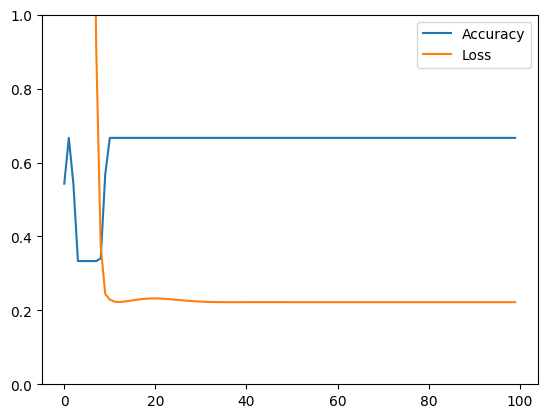

In [53]:
# create training mask for playlist nodes
train_mask = torch.zeros(ghetero["playlist"].x.shape[0], dtype=torch.bool)
train_mask[torch.randperm(train_mask.shape[0])[:int(train_mask.shape[0]*0.8)]] = True

ghetero["playlist"].train_mask = train_mask

ghetero["playlist"].y = torch.LongTensor([1]*ghetero["playlist"].x.shape[0]).to(device)

model = HeteroModel(64, ghetero.x_dict, ghetero.metadata()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
edge_label_index = data_train["track", "contains", "playlist"].edge_label_index
edge_label = data_train["track", "contains", "playlist"].edge_label

def kek(*k,**k1):
    print("to device called", k, k1)
    return T.ToDevice(device)(*k,**k1)

train_loader = torch_geometric.loader.LinkNeighborLoader(
    data=data_train,
    num_neighbors=[50, 30],
    neg_sampling_ratio=2.0,
    edge_label_index=(("track", "contains", "playlist"), edge_label_index),
    edge_label=edge_label,
    batch_size=10000,
    shuffle=True,
    transform=T.ToDevice(device)
)

import tqdm
epoch = 100

render_graph = True

losses = []
accuracies = []

epoch_iter = tqdm.tqdm(range(epoch), unit='epoch', desc='Training', bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:10}{r_bar}')
for i in epoch_iter:
    loss, accuracy = train(model, train_loader, optimizer)
    losses.append(loss)
    accuracies.append(accuracy)
    epoch_iter.set_postfix_str(f"Loss: {loss:.4f}, Accuracy {accuracy:.4f}")

plt.clf()
# add labels
plt.plot(np.arange(len(accuracies)), accuracies, label='Accuracy')
plt.plot(np.arange(len(losses)), losses, label='Loss')
# add legend

#start plot at 0
plt.ylim(0, 1)
plt.legend()
plt.show()